# Back Propagation

Here is an implementation of the basic back propagation algorithm. This is meant for educational purposes and should not be used in any production environment.

In this notebook, we will implement our back propagation algorithm using gradient descent and Relu non-linearities through a small network. We will also test our back propagation implementation against a simple problem of approximating mathematical functions.

I will not explain in detail the mathematics and reasoning of the implementation, but will link to external sources that do a sufficient job at doing so. [Here](http://neuralnetworksanddeeplearning.com/chap2.html) is a good place to start for getting a foundation of back propagation.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

All the models to learn in this network will take 2 inputs and give 1 output. The output is a classification variable that can take on a value between 0 and 1. Values closer to 0 indicate preference for class 0 while values for class 1 prefer class 1.

We will define 3 functions that our neural networks should learn after training:

## Model 1: Inside of Ellipsis

In [7]:
num_points = 10000

In [8]:
def create_ellipse_func(a, b):
    def ellipse_func(x, y):
        return 1 if ((x*x) / (a*a) + (y*y) / (b*b)) <= 1 else 0

    return ellipse_func


In [9]:
model1_func = create_ellipse_func(2.0, 4.0)
model1_points = 8 * np.random.rand(2, num_points) - 4
model1_categories = np.apply_along_axis(lambda x: model1_func(x[0], x[1]), axis=0, arr=model1_points)

split_mask = np.random.rand(num_points) <= 0.6

model1_training = model1_points[:, split_mask]
model1_training_categories = model1_categories[split_mask]

model1_test = model1_points[:, ~split_mask]
model1_test_categories = model1_categories[~split_mask]

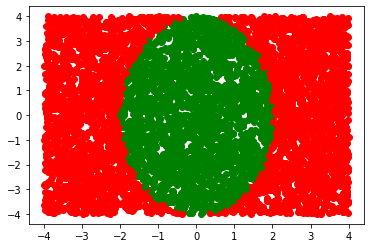

In [10]:
# Let's make a plot to see where the ellipse is being drawn.

for i in range(len(model1_training_categories)):
    point = model1_training[:, i]
    category = model1_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Model 2: Guassian

In [11]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [12]:
model2_func = create_gaussian_curve(0.0, 0.05)
model2_points = np.random.rand(2, num_points) * 4 - 2
model2_categories = np.apply_along_axis(lambda x: model2_func(x[0], x[1]), axis=0, arr=model2_points)

split_mask = np.random.rand(num_points) <= 0.6

model2_training = model2_points[:, split_mask]
model2_training_categories = model2_categories[split_mask]

model2_test = model2_points[:, ~split_mask]
model2_test_categories = model2_categories[~split_mask]

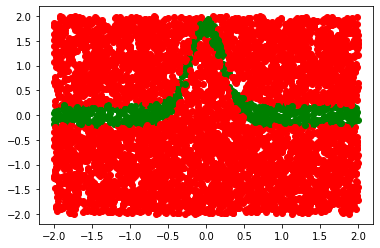

In [13]:
# Let's make a plot to see where the ellipse is being drawn.

for i in range(len(model2_training_categories)):
    point = model2_training[:, i]
    category = model2_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Feed Forward Network

We will design a simple feed-forward network with relu activation.

### Activation Functions

In [14]:
def relu(X):
    mask = X >= 0
    return X * mask
    

In [26]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [15]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [27]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [28]:
def binary_cross_entropy_loss(output, expected):
    # Note that this function will throw errors if any of the output
    # values are 0 or 1 exactly.
    m = output.shape[1]
    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output)) / m


In [38]:
def binary_cross_entropy_loss_grad(output, expected):
    # Note that this function will throw errors if any output is 0.
    m = output.shape[1]
    return (1. / m) * ((expected / output) - (1 - expected) / (1 - output))


### Model

In [17]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers
    

In [18]:
model1 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[3, 4]) }

model2 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[3, 4]) }


In [19]:
def forward(model, X):
    Y = X

    liner_outputs = []
    outputs = []

    for (i, (weights, biases)) in enumerate(model['layers'][0:-1]):
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    model['linear_outputs'] = linear_outputs
    model['outputs'] = outputs
    model['result'] = Y

    return results
 

In [20]:
def predict(model, X, threshold=0.5):
    Y = forward(model, X)
    return Y >= threshold
    

In [ ]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass and a loss computation and we are now doing
    # a back propagation of errors.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    loss_gradient = model['loss_gradient']

    error_last_layer = loss_gradient * linear_outputs[-1]
    bias_gradient_last_layer = error_last_layer
    # TODO: HERE I AM! HOW DO I HANDLE THE FACT THAT THE OUTPUTS
    # COULD HAVE MANY SAMPLES??
    weights_gradient_last_layer = np.dot() # outer product
    gradient_last_layer = (, error_last_layer)

    errors = []
    gradients = []
    
    for i in range(len(layers) - 1):
        

    